In [1]:
import sys
import json
import itertools
from datetime import datetime
from pathlib import Path

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

# 1. Add parent directory to path
sys.path.append(str(Path("..").resolve()))

from data_handling import (
    load_measurements_npz,
    load_state_npz,
    MeasurementDataset,
    MeasurementLoader
)

# 2. Import modularized code
from model import ConditionalRBM, train_loop, get_sigmoid_curve, save_model

# Define paths
data_dir = Path("measurements")
state_dir = Path("state_vectors")
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

# Set global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cpu


In [2]:
def generate_all_states(num_qubits: int, device: torch.device):
    """Generates all 2^N basis states."""
    lst = list(itertools.product([0, 1], repeat=num_qubits))
    return torch.tensor(lst, dtype=torch.float32, device=device)

@torch.no_grad()
def compute_overlap(model, h_val, gt_path, all_states):
    """Computes overlap between RBM wavefunction and Ground Truth."""
    psi_np, _ = load_state_npz(gt_path)
    psi_true = torch.from_numpy(psi_np).real.float().to(device)
    psi_true = psi_true / torch.norm(psi_true) # Ensure GT is normalized

    cond = torch.tensor([h_val], device=device, dtype=torch.float32)
    # Uses the method from the imported ConditionalRBM class
    psi_model = model.get_normalized_wavefunction(cond, all_states)

    return torch.abs(torch.dot(psi_true, psi_model)).item()

In [4]:
GEN_SIDE_LENGTH = 4
FILE_SAMPLE_COUNT = 20_000
TRAIN_SAMPLE_COUNT = 20_000
N_EPOCHS = 50

# Load support and novel points
h_support = [1.00, 1.10, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 5.0]
h_novel   = [2.80, 3.20]
all_h_values = sorted(list(set(h_support + h_novel)))

file_names = [f"tfim_{GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}_h{h:.2f}_{FILE_SAMPLE_COUNT}.npz" for h in h_support]
file_paths = [data_dir / fn for fn in file_names]

# Simple check
missing = [fp for fp in file_paths if not fp.exists()]
if missing:
    print(f"Warning: Missing {len(missing)} files.")

seed = 42
torch.manual_seed(seed)
rng = torch.Generator().manual_seed(seed)

print(f"Training on {TRAIN_SAMPLE_COUNT} samples per point.")
print(f"Support points: {h_support}")

# 1. Dataset
ds = MeasurementDataset(file_paths, load_measurements_npz, ["h"], [TRAIN_SAMPLE_COUNT]*len(file_paths))
loader = MeasurementLoader(ds, batch_size=1024, shuffle=True, drop_last=False, rng=rng)

# 2. Model & Optimizer
model = ConditionalRBM(ds.num_qubits, num_hidden=64, cond_dim=1, conditioner_width=64, k=10).to(device)
# Note: Module sets std=0.01 by default, but you can override: model.initialize_weights(std=0.05) if needed

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = get_sigmoid_curve(1e-2, 1e-4, N_EPOCHS*len(loader), 0.005)

# 3. Training (Using Module)
print("\nStarting Training...")
model = train_loop(
    model,
    optimizer,
    loader,
    num_epochs=N_EPOCHS,
    lr_schedule_fn=scheduler,
    noise_frac=0.1,
    rng=rng
)

# 4. Evaluation
print("\nEvaluating Overlap...")
all_states = generate_all_states(GEN_SIDE_LENGTH**2, device)

results = []
for h_val in all_h_values:
    gt_path = state_dir / f"tfim_{GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}_h{h_val:.2f}.npz"
    if gt_path.exists():
        ov = compute_overlap(model, h_val, gt_path, all_states)
        rtype = "support" if h_val in h_support else "novel"
        results.append({"h": h_val, "overlap": ov, "type": rtype})
        print(f"h={h_val:.2f} ({rtype:7}) | Overlap = {ov:.5f}")

print("\nFinished.")

Training on 20000 samples per point.
Support points: [1.0, 1.1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0]

Starting Training...
Epoch  | Loss       | LR        
-----------------------------------
1      | +0.0390     | 0.010000
10     | +0.0079     | 0.010000
20     | +0.0052     | 0.009881
30     | +0.0012     | 0.000221
40     | -0.0023     | 0.000100
50     | -0.0019     | 0.000100

Evaluating Overlap...
h=1.00 (support) | Overlap = 0.99982
h=1.10 (support) | Overlap = 0.99982
h=1.50 (support) | Overlap = 0.99963
h=2.00 (support) | Overlap = 0.99883
h=2.50 (support) | Overlap = 0.99779
h=2.80 (novel  ) | Overlap = 0.99765
h=3.00 (support) | Overlap = 0.99773
h=3.20 (novel  ) | Overlap = 0.99782
h=3.50 (support) | Overlap = 0.99786
h=4.00 (support) | Overlap = 0.99818
h=5.00 (support) | Overlap = 0.99880

Finished.


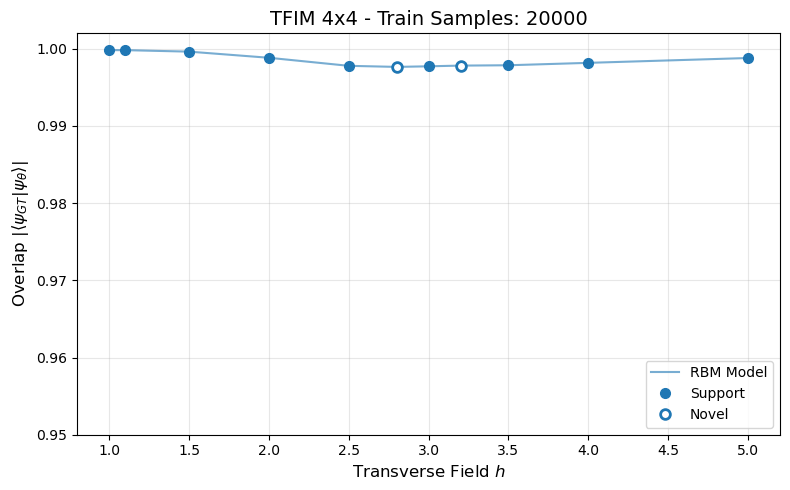

In [5]:
df = pd.DataFrame(results)
supp = df[df["type"] == "support"]
nov  = df[df["type"] == "novel"]

plt.figure(figsize=(8, 5), dpi=100)
plt.plot(df["h"], df["overlap"], '-', color='tab:blue', alpha=0.6, label="RBM Model")
plt.plot(supp["h"], supp["overlap"], 'o', color='tab:blue', markersize=7, label="Support")
plt.plot(nov["h"], nov["overlap"], 'o', color='tab:blue', markerfacecolor='white', markeredgewidth=2, markersize=7, label="Novel")

plt.xlabel(r"Transverse Field $h$", fontsize=12)
plt.ylabel(r"Overlap $|\langle \psi_{GT} | \psi_{\theta} \rangle|$", fontsize=12)
plt.title(f"TFIM 4x4 - Train Samples: {TRAIN_SAMPLE_COUNT}", fontsize=14)
plt.ylim(0.95, 1.002)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [6]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"crbm_tfim_4x4_{TRAIN_SAMPLE_COUNT}_suscept_{timestamp}.pt"
save_path = models_dir / filename

config = {
    "train_samples": TRAIN_SAMPLE_COUNT,
    "epochs": N_EPOCHS,
    "h_support": h_support
}

# The save_model function automatically adds model params (visible/hidden/k) to the config
save_model(model, optimizer, config, results, save_path)

Model saved to: models/crbm_tfim_4x4_20000_suscept_20260113_190009.pt
